In [ ]:
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
import numpy as np


import os


This simulation solves the bounce-averaged pure pitch-angle diffusion equation using the Crank-Nicolson method. All computations are done in Gaussian units.

In [ ]:
# general sim parameters for t and a, important constants

N_alpha = 360
# this linspace defines the N+1 cell edges
a = np.linspace(0, np.pi/2, num=N_alpha+1)  # avoid 0, pi/2 singularities
da = a[1]-a[0]
a_centers = np.linspace(1/2*da, np.pi/2-1/2*da, N_alpha)
a_plot = np.hstack((a[0], a_centers, a[-1]))

dt = 0.05
stop_time = 30      # should be a multiple of 5
t_range = np.linspace(0, stop_time, num=int(stop_time/dt)+1)

# solver outputs
save_frequency = 0.25      # save f for plotting every n seconds of simulation time
save_times = np.linspace(0, stop_time, num=int(stop_time/save_frequency)+1)
# print(save_times)
saved_f = np.zeros((len(a_plot), len(save_times)))
steady_state = np.zeros(a.shape) 

N = np.zeros(t_range.shape)     # number of particles; saved at all simulation times

# output directory
RUN_NAME = "50keV_L5"
PLOTS_DIRECTORY = "plots/" + RUN_NAME + "/"
DATA_DIRECTORY = "data/" + RUN_NAME + "/"

if not os.path.exists(PLOTS_DIRECTORY) or not os.path.isdir(PLOTS_DIRECTORY):
    os.makedirs(PLOTS_DIRECTORY)

if not os.path.exists(DATA_DIRECTORY) or not os.path.isdir(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)

In [ ]:
# constants
mec2 = 511000           # keV
me = 9.109E-28          # g
c = 29979245800         # cm/s
Bo = 0.312              # G
Re = 6371 * 1000 * 100  # cm

# of the edges
sina = np.sin(a)
sin2a = np.sin(2*a)
cosa = np.cos(a)
cos2a = np.cos(2*a)
Ta = 1.3 - 0.56*sina
# dTda = np.ones(a.shape) * 0.56 * cosa

dirac90 = np.zeros(a_plot.shape)
dirac90[-1] = 1
dirac90[-2] = 1/2

dirac0 = np.zeros(a_plot.shape)
dirac0[1] = 1
dirac0[2] = 1/2

In [ ]:
# particle conditions/characteristics

# B-field related
L_shell = 5   
a_L = np.asin(np.sqrt(1/L_shell**3 * 1/np.sqrt(4-3/L_shell)))   # radians

# particle energy related
E_k = 50000                 # keV
gam_rel = 1 + E_k/mec2
v = c * np.sqrt(1 - 1/(gam_rel)**2)     # cm/s

# characteristic loss timescale
t_L = Re * L_shell/v * (1.3 - 0.56*np.sin(a_plot))    # s
heaviside_adaL = np.heaviside(a_plot-a_L, np.zeros(a_plot.shape))


In [ ]:
# diffusion and simulation conditions

# diffusion coefficient as a function of a at the edges
Dstar = 1
Daa = np.ones(a.shape) * Dstar / np.cos((a)*(np.heaviside(a-a_L, np.zeros(a.shape))))

save = True

# loss coefficient as a function of a
L = np.ones(a_plot.shape) * 1/t_L * np.heaviside(-(a_plot-a_L), 0.5*np.ones(a_plot.shape))
print(f"Equatorial loss cone: {np.round(a_L * 180/np.pi, decimals=4)} deg")

# source term as a function of a
S = dirac90 * 20000
# 1 for 0.0001, 0.001; 100 for 0.01, 1000 for 0.1, 20000 for 1

# distribution initial condition
f0 = np.ones(a_plot.shape) * 1 # * np.sin(a_plot)**2       # uniform distribution; counts/rad
N0 = sum(f0)                     # number of particles initially; if S=L=0, this should be conserved

# plt.plot(a, Daa)
# plt.show()

In [ ]:
# set up and solve fat matrix inversions for each timestep

save_col = 0
f = f0
f_prev = f0 # np.zeros(f0.shape)
for time, n in zip(t_range, range(len(t_range))):
    N[n] = sum(f[1:-1]*da)
    if time in save_times:
        saved_f[:,save_col] = f     # save f @ t_n
        save_col = save_col + 1

        # print(f"time: {np.round(time, decimals=5)}\t\tparticles: {N[n]}")
        # if time % 60 == 0:
        # plt.figure()
        # plt.plot(a_plot[1:-1]*180/np.pi,f[1:-1])
        # plt.grid(True)
        # plt.xlim((0, 90))
        # plt.xlabel('Pitch angle (degrees)')
        # plt.ylabel('f')
        # plt.show()
        
    # compute coefficients for each alpha
    A = np.zeros(a_plot.shape)
    B = np.zeros(a_plot.shape)
    C = np.zeros(a_plot.shape)
    D = np.zeros(a_plot.shape)

    for i in range(len(a)-1): #
        a_center = a_centers[i]
        # print(f"Lower: {np.round(a[i], decimals=6)} Center: {np.round(a_center, decimals=6)} Upper: {np.round(a[i+1], decimals=6)}")
        
        sin2aTa_upper = sin2a[i+1]*Ta[i+1]
        sin2aTa_lower = sin2a[i]*Ta[i]
        sin2aTa_center = np.sin(2*a_center)*(1.3-0.56*np.sin(abs(a_center)))

        A[i+1] = -dt/da**2 * sin2aTa_lower*Daa[i] / sin2aTa_center
            
        B[i+1] = 3/2 + dt/da**2 * (sin2aTa_upper*Daa[i+1] + sin2aTa_lower*Daa[i])/sin2aTa_center
        
        C[i+1] = -dt/da**2 * sin2aTa_upper*Daa[i+1] / sin2aTa_center

        # if abs(a_center) < 0.1:     # use small angle approx to avoid singularity entirely
        #     # print(f"a_center = {np.round(a_center, decimals=5)}\tupper: {np.format_float_scientific(sin2aTa_upper, precision=5)}\tcenter: {np.format_float_scientific(sin2aTa_center, precision=5)}\tlower: {np.format_float_scientific(sin2aTa_lower, precision=5)}")
        #     B[i+1] = 3/2 + dt/da**2 * (Daa[i+1]+Daa[i])
        #     A[i+1] = -dt/da**2 * Daa[i]
        #     C[i+1] = -dt/da**2 * Daa[i+1]

        D[i+1] = 2*f[i+1] - 1/2 * f_prev[i+1] - L[i]*f[i+1] + S[i+1]

    A[0] = 0
    B[0] = -1/da
    C[0] = 1/da
    D[0] = 0

    A[-1] = -1/da
    B[-1] = 1/da
    C[-1] = 0
    D[-1] = 0 # f[-1] - L[i]*f[-1] + S[-1]

    # if time in save_times:
    # plt.plot(a_plot, D)
    # plt.show()

  
    # solve_banded and get f @ t_n+1
    inversion_matrix = np.vstack((C,B,A))

    # print(inversion_matrix)

    f_prev = f
    f = solve_banded((1,1), inversion_matrix, D)        # f at time n+1
    
steady_state = saved_f[:,-1:]
if save:
    with open("steady_state.txt", "ab") as file:
        np.savetxt(file, steady_state.T,delimiter=',')
        file.write(b"\n")


In [ ]:

plt.plot(t_range, N)
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Particle count N')
plt.xlim((0,stop_time))
plt.show()


plt.figure()

plot_times = np.hstack((save_times[0:5], save_times[-80], save_times[-30],save_times[-1]))
plot_f = np.hstack((saved_f[:,0:5], saved_f[:,-80:-79], saved_f[:,-30:-29], saved_f[:,-1:]))
for (t, f) in zip(plot_times, plot_f.T):
    plt.plot(a_plot[1:-1]*180/np.pi, f[1:-1], label=f"t={np.round(t,decimals=2)}")
plt.grid(True)
plt.xlabel("Pitch angle (degrees)")
plt.ylabel("f")
plt.xlim((0,90))
plt.legend()
plt.show()

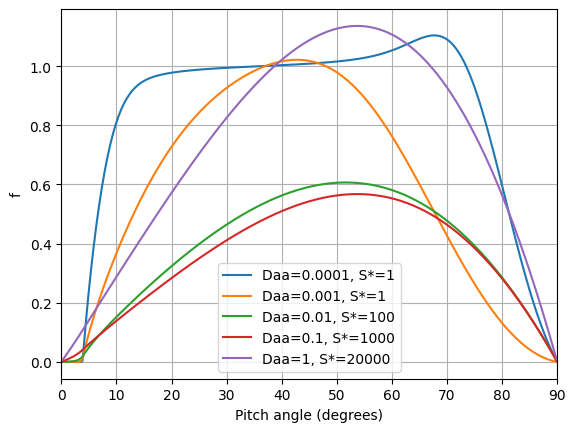

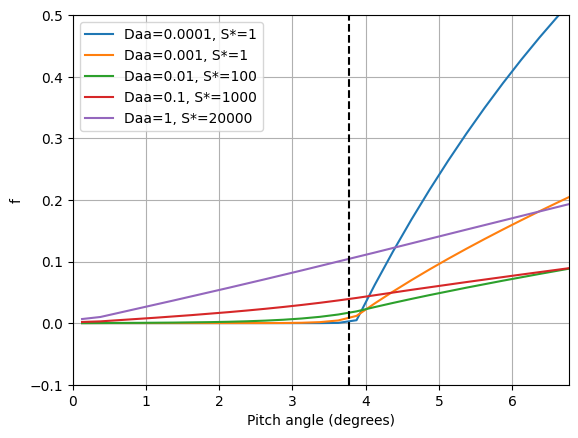

In [64]:
if save:
    filename = 'steady_state.txt'
    Daa_list = [1E-4, 1E-3, 1E-2, 1E-1, 1]
    S_list = [1, 1, 100, 1000, 20000]

    steady_state_fs = np.loadtxt(filename, delimiter=',')
    plt.figure()
    for Da, Sstar, f in zip(Daa_list, S_list, steady_state_fs):
        plt.plot(a_plot[1:-1]*180/np.pi, f[1:-1], label=f"Daa={Da}, S*={Sstar}")
    plt.grid(True)
    plt.xlabel("Pitch angle (degrees)")
    plt.ylabel("f")
    plt.xlim((0,90))
    plt.legend()
    plt.show()

    plt.figure()
    for Da, Sstar, f in zip(Daa_list, S_list, steady_state_fs):
        plt.plot(a_plot[1:-1]*180/np.pi, f[1:-1], label=f"Daa={Da}, S*={Sstar}")
    plt.grid(True)
    plt.vlines(a_L*180/np.pi, -0.1, 0.5, color='black', linestyles='dashed')
    plt.xlabel("Pitch angle (degrees)")
    plt.ylabel("f")
    plt.xlim((0,a_L*180/np.pi+3))
    plt.ylim((-0.1,0.5))
    plt.legend()
    plt.show()


In [ ]:
#    for i in range(len(a)-1): #
#         a_center = a_centers[i]
#         # print(f"Lower: {np.round(a[i], decimals=6)} Center: {np.round(a_center, decimals=6)} Upper: {np.round(a[i+1], decimals=6)}")
        
#         sin2aTa_upper = sin2a[i+1]*Ta[i+1]
#         sin2aTa_lower = sin2a[i]*Ta[i]
#         sin2aTa_center = np.sin(2*a_center)*(1.3-0.56*np.sin(a_center))


#         A[i+1] = -dt/da**2 * sin2aTa_lower*Daa[i] / sin2aTa_center
            
#         B[i+1] = 3/2 + dt/da**2 * (sin2aTa_upper*Daa[i+1] + sin2aTa_lower*Daa[i])/sin2aTa_center
        
#         C[i+1] = -dt/da**2 * sin2aTa_upper*Daa[i+1] / sin2aTa_center

#         D[i+1] = 2*f[i+1] - 1/2 * f_prev[i+1]


#     # plt.figure()
#     # plt.plot(a_plot, A)
#     # plt.plot(a_plot, B)
#     # plt.plot(a_plot, A)
#     # plt.plot(a_plot, A)
#     # plt.show()

#     A[0] = 0
#     B[0] = B[1]
#     C[0] = C[1]
#     D[0] = -D[1]

#     A[-1] = A[-2]
#     B[-1] = B[-2]
#     C[-1] = 0
#     D[-1] = -D[-2]

In [ ]:
  # for alpha, j in zip(a, range(len(a))):
    #     if j == 0:      # boundary condition: df/da = 0 @ alpha = 0
    #         A[j] = 0 
    #         B[j] = -1/(4*da) # 1/dt + L[j]/2 + Daa[j]/(da**2)
    #         C[j] = 1/(4*da) # -K[j]/(16*da**2) - Daa[j]/(2*da**2) 
    #         D[j] = 0 # S[j]

    #         # D[j] = ((1/dt - L[j]/2 - Daa[j]/(da**2))*f[j] +
    #         #         (K[j]/(16*da**2) + Daa[j]/(2*da**2))*f[j+1]) + S[j]
                  
    #     elif j == len(a) - 1:       # boundary condition: df/da = 0 @ alpha = pi/2
    #         A[j] = -1/(4*da) # K[j-1]/(16*da**2) - Daa[j]/(2*da**2) 
    #         B[j] = 1/(4*da) # 1/dt + L[j]/2 + Daa[j]/(da**2)
    #         C[j] = 0 
    #         D[j] = 0 # S[j]
    #         # D[j] = ((-K[j-1]/(16*da**2) + Daa[j]/(2*da**2))*f[j-1] +
    #         #         (1/dt - L[j]/2 - Daa[j]/(da**2))*f[j]) + S[j]  
    #     else:
    #         K[j] = (sin2a[j+1]*Ta[j+1]*Daa[j+1] - sin2a[j]*Ta[j]*Daa[j]) / (sin2a[j]*Ta[j])

    #         A[j] = K[j]/(16*da**2) - Daa[j]/(2*da**2)
            
    #         B[j] = 1/dt  + Daa[j]/(da**2)

    #         C[j] = -K[j]/(16*da**2) - Daa[j]/(2*da**2)

    #         D[j] = ((-K[j]/(16*da**2) + Daa[j]/(2*da**2))*f[j-1] +
    #                 (1/dt - L[j] - Daa[j]/(da**2))*f[j] +
    #                 (K[j]/(16*da**2) + Daa[j]/(2*da**2))*f[j+1]) + S[j] 
